In [50]:
#Import data manipulation libaries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [51]:
#Plotting
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import gc


from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#### First data loading strategy

In [52]:
#train_import = pd.read_csv("/kaggle/input/playground-series-s3e11/train.csv")
#test_df = pd.read_csv("/kaggle/input/playground-series-s3e11/test.csv")
#submission = pd.read_csv("/kaggle/input/playground-series-s3e11/sample_submission.csv")

In [53]:
#train_import.info()

### Binary data

In [54]:
train_bin = pd.read_csv("/kaggle/input/playground-series-s3e12/train.csv", index_col='id')
test_bin = pd.read_csv("/kaggle/input/playground-series-s3e12/test.csv", index_col='id')
submission_bin = pd.read_csv("/kaggle/input/playground-series-s3e12/sample_submission.csv")

In [55]:
train_bin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  414 non-null    float64
 1   ph       414 non-null    float64
 2   osmo     414 non-null    int64  
 3   cond     414 non-null    float64
 4   urea     414 non-null    int64  
 5   calc     414 non-null    float64
 6   target   414 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 25.9 KB


#### Second data loading strategy
Loading another training data set
Adding a flag for the adversial cross-validation

In [56]:
#test = pd.read_csv('/kaggle/input/playground-series-s3e6/test.csv')
#test.drop("id",axis=1,inplace=True)
#test['adv_val'] =  0

#train = pd.read_csv('/kaggle/input/playground-series-s3e6/train.csv')
#train.drop("id",axis=1,inplace=True)
#train['adv_val'] =  1

#original = pd.read_csv('/kaggle/input/paris-housing-price-prediction/ParisHousing.csv')
#original['adv_val'] =  2

#sample = pd.read_csv('/kaggle/input/playground-series-s3e6/sample_submission.csv')

In [57]:
#sets={'train':train,'test':test,'original':original}

In [58]:
#Define the target label
#target='price'

In [59]:
#original.head(2)

#### Target correlation

In [60]:
def corr_to_target(dataframe, target, title=None, file=None):
    plt.figure(figsize=(8,8))
    sns.set(font_scale=1)
    
    sns.heatmap(dataframe.corr()[[target]].sort_values(target,
                                                ascending=False)[1:10],
                annot=True,
                cmap='Accent')
    
    if title: plt.title(f'\n{title}\n', fontsize=10)
    plt.xlabel('')    # optional in case you want an x-axis label
    plt.ylabel('')    # optional in case you want a  y-axis label
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show()
    
    return

### Feature Distribution - Univariate

In [61]:
#########################################################################
### The function for data distribution analysis between two datasets  ###
#########################################################################

def viz_comp (data1,data2,title):
    n_bins = 50
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    cols=num_cols
    fig, ax = plt.subplots(len(cols)//3+1,3, figsize=(20, 20))
    ax = ax.flatten()

    for i, column in enumerate(cols):
        sns.histplot(
            data1[column], label='Train',
            ax=ax[i], color='green', **histplot_hyperparams)

    for i, column in enumerate(cols):
        sns.histplot(
            data2[column], label='Train',
            ax=ax[i], color='red', **histplot_hyperparams)
    ax[0].set_title(title, fontstyle='normal',size=25)

In [62]:
#def miss_values_check(data,n):
 #   print(f'\033[0;33;40m A number of NaN values in {n} is {data.isnull().sum().sum()} \033[0;30;0m')
  #  if data.isnull().sum().sum() >0:
   #     sns.heatmap(data.isnull())
#for n in sets:
 #   miss_values_check(sets[n],n)

In [63]:
def create_EDA_summary (df = None):
    train_import_table = pd.DataFrame()
    train_import_table["dtype"] = df.apply(lambda x: x.dtype)
    train_import_table["NROW"] = df.shape[0]
    train_import_table["Unique_values"] = [ len(df[col].unique()) for col in df.columns]
    train_import_table["Percent_missing"] = (df.isnull().sum()/df.shape[0])*100
    
    return train_import_table

#### Adversarial cross-validation

In [64]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [65]:
from sklearn.utils import shuffle

def adv_validation (data_1,data_2,key):
    X_temp=shuffle(pd.concat([data_1,data_2],ignore_index=True))
    if key == True:
        adv_list = ['adv_val']
    else:
        adv_list = ['adv_val',target]
        
    X_full=X_temp.drop(adv_list,axis=1)
    y_full=X_temp.adv_val
    X_full,y_full=shuffle(X_full,y_full)
    X_full=X_full.reset_index(drop=True)
    y_full=y_full.reset_index(drop=True)
    result = cross_val_score(lgb.LGBMClassifier(n_estimators=200),X_full,y_full,scoring='roc_auc',cv=5).mean()
    return result

In [66]:
#sets_adv_val={'train':train,'original':original}
#for one in sets_adv_val:
    #print (f'\033[0;33;40m Result between {one} and test = {adv_validation(sets_adv_val[one],test,False)} \033[0;30;0m')

#### Permutation Importance

In [67]:
import eli5
from eli5.sklearn import PermutationImportance
##############################
### Permutation importance ###
##############################

def permutation_importance(model,X,y):
    permute = PermutationImportance(model,random_state=2023,n_iter =10,cv=5).fit(X, y)
    eli5.show_weights(permute, feature_names = X.columns.tolist(),top=50)
    values = dict(zip(list(train.columns),list(permute.feature_importances_)))
    sorted_dict = {}
    sorted_keys = sorted(values, key=values.get)
    for w in sorted_keys:
        sorted_dict[w] = values[w]

In [68]:
# Permuation Importance with LGBM
#model = lgb.LGBMClassifier(n_estimators=100)
#X=shuffle(pd.concat([original,test],ignore_index=True).drop(['adv_val',target],axis=1),random_state=2023).reset_index(drop=True)
#y=shuffle(pd.concat([original,test],ignore_index=True).adv_val,random_state=2023).reset_index(drop=True)
#metric='roc_auc'
#permute = PermutationImportance(model,random_state=2023,n_iter =10,cv=5,scoring = metric).fit(X, y)
#eli5.show_weights(permute, feature_names = X.columns.tolist(),top=50)

In [69]:
#adv_final = adv_validation(train[['squareMeters','adv_val','price']],
                           #test[['squareMeters','adv_val']],
                           #False)
#print (f'\033[0;33;40m Result between train and test = {adv_final} \033[0;30;0m')

In [70]:
#adv_final = adv_validation(train[['squareMeters','price','adv_val']],
                          # original[['squareMeters','price','adv_val']],
                           #True)
#print (f'\033[0;33;40m Result between train and original = {adv_final} \033[0;30;0m')

In [71]:
#Combine train and priginbal data after the adversarial cross-validation
#train=pd.concat([train,original],ignore_index=True)

In [72]:
#Drop the adversarial column
#train=train.drop('adv_val',axis=1)
#test=test.drop('adv_val',axis=1)
#original=original.drop('adv_val',axis=1)

In [73]:
#X = train.drop([target],axis=1)
#y = train[target]
#X,y=shuffle(X,y,random_state=2023)
#X = X.reset_index(drop=True)
#y = y.reset_index(drop=True)

In [82]:
##########################################
### It is the most valnurable features ###
##########################################
num_cols_outl=['squareMeters']

from sklearn.neighbors import LocalOutlierFactor
cont_FEATURES = num_cols_outl

def plot_outliers(data,target,df, feature, threshold=8):
    mean, std = np.mean(df), np.std(df)
    z_score = np.abs((df-mean) / std)
    good = z_score < threshold
    print(f"\033[0;33;40m Rejection {(~good).sum()} points \033[0;30;0m ")
    visual_scatter = np.random.normal(size=df.size)
    plt.scatter(df[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
    plt.scatter(df[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.show();
    data,target = data[good],target[good]
    return data,target

#for feature in cont_FEATURES:
    #print(feature)
    #X,y = plot_outliers(X,y,X[feature], feature)

In [83]:
create_EDA_summary(train_bin)

,dtype,NROW,Unique_values,Percent_missing
gravity,float64,414,28,0.0
ph,float64,414,71,0.0
osmo,int64,414,80,0.0
cond,float64,414,65,0.0
urea,int64,414,73,0.0
calc,float64,414,85,0.0
target,int64,414,2,0.0


In [84]:
train_bin.head()

,gravity,ph,osmo,cond,urea,calc,target
id,,,,,,,
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


#### Heatmap

In [85]:
def heatmap(df = None):
    plt.figure(figsize=(18, 8))
    mask = np.triu(np.ones_like(df.corr()))
    sns.heatmap(df.corr(),cmap='YlOrRd',annot=True,mask=mask)

### EDA for e3S12

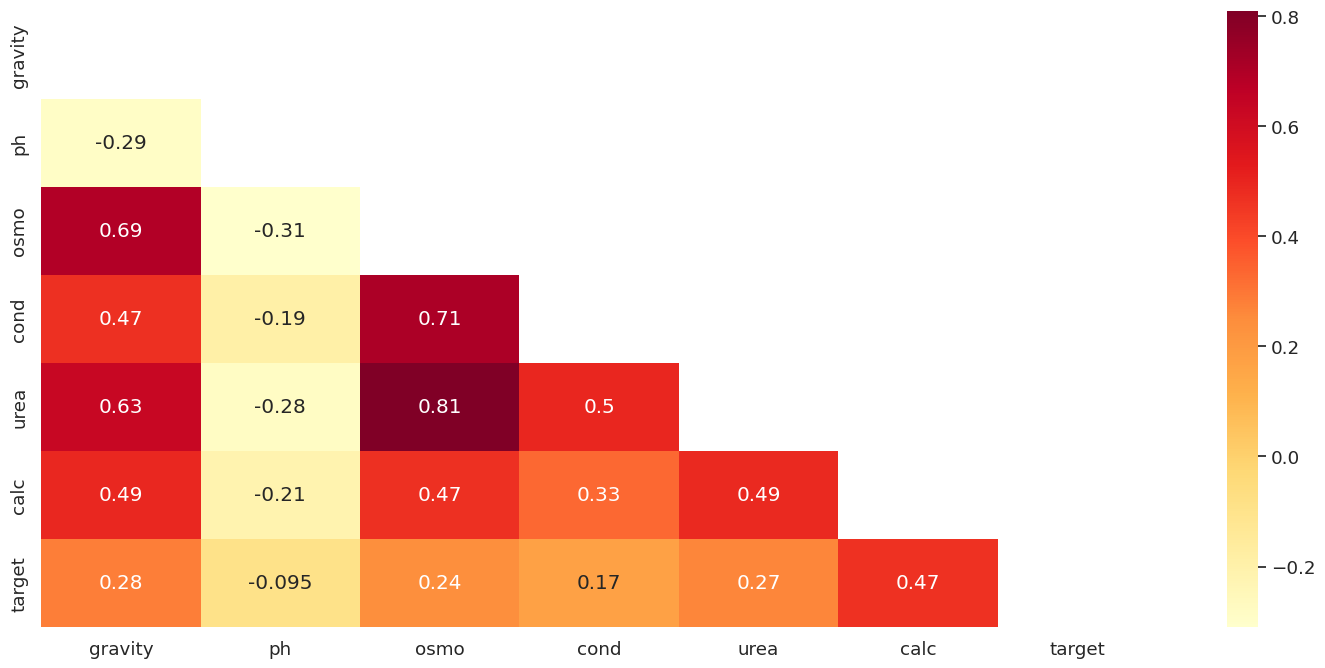

In [86]:
heatmap(train_bin)

In [87]:
def univariate(train = None, test = None):
    n_cols = 3
    n_rows = (len(test.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

    for i, var_name in enumerate(test.columns.tolist()):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.distplot(train[var_name], kde=True, ax=ax, label='Train')
        sns.distplot(test[var_name], kde=True, ax=ax, label='Test')
        #sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

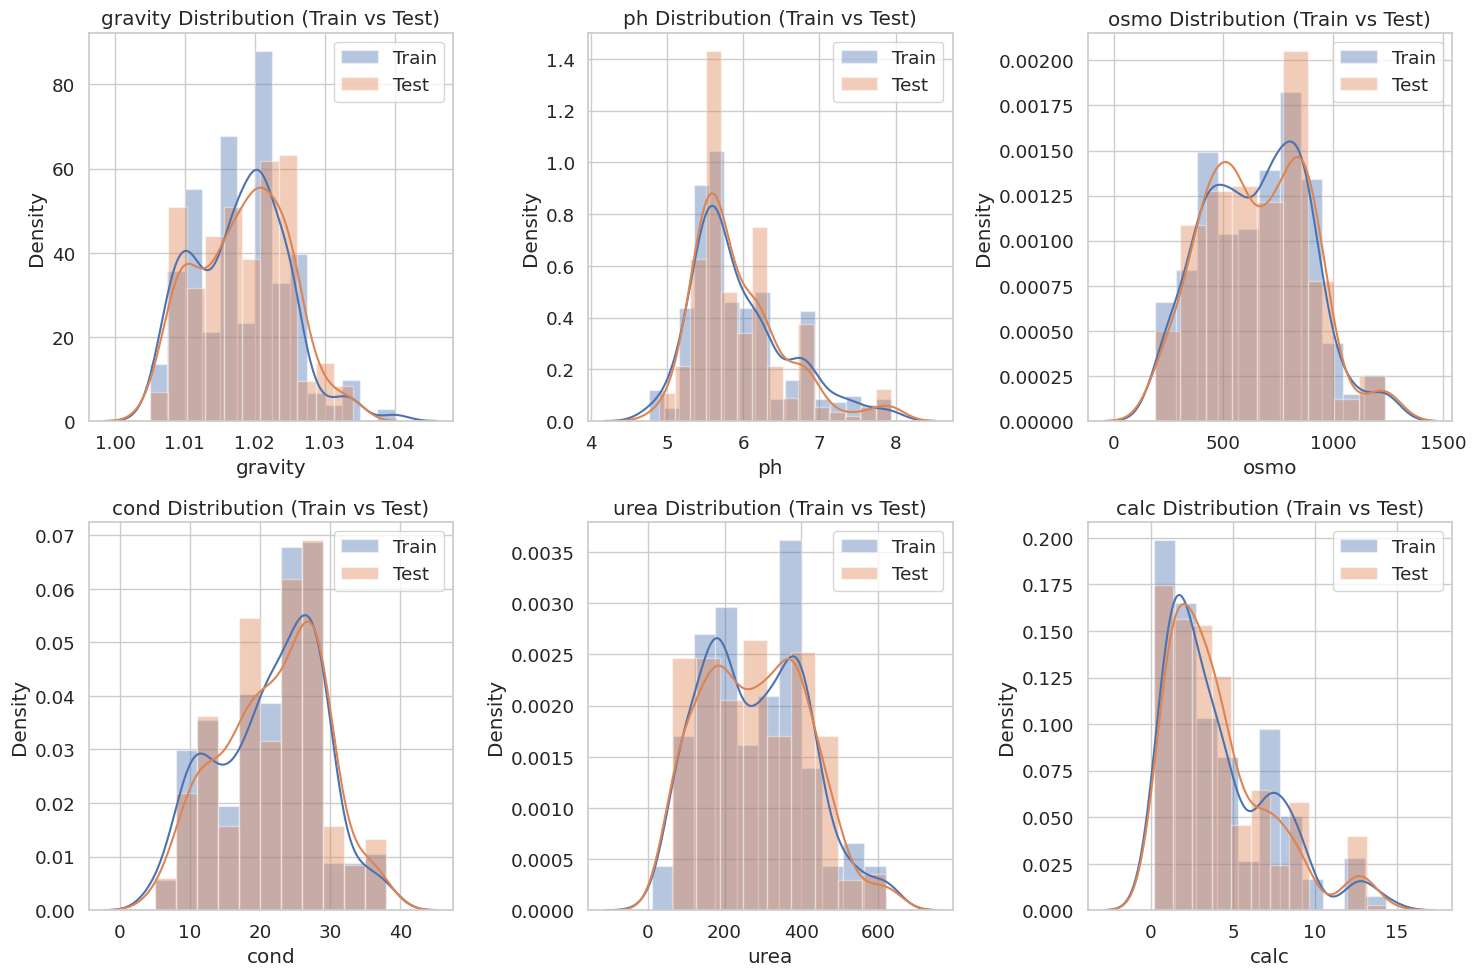

In [88]:
univariate(train_bin, test_bin)

In [89]:
def dist_by_target(train = None, test = None, target_col = ""):
    num_cols = 3
    num_rows = (len(test.columns)) // num_cols
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 4*num_rows))
    sns.set(font_scale=1.2, style='whitegrid')

    for i, col_name in enumerate(test.columns):

        ax = axes[i // num_cols, i % num_cols]
        sns.kdeplot(data=train, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)

            # sns.kdeplot(data=original, x=col_name, hue=target_col, ax=ax, fill=True, alpha=0.5, linewidth=2)

        ax.set_title(f'{col_name.title()} Distribution by {target_col.title()}', fontsize=18)
        ax.set_xlabel(col_name.title(), fontsize=14)
        ax.set_ylabel(target_col.title(), fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.legend([1, 0], title=target_col.title(), fontsize=12)

    plt.tight_layout(h_pad=1, w_pad=0.8)
    plt.show()

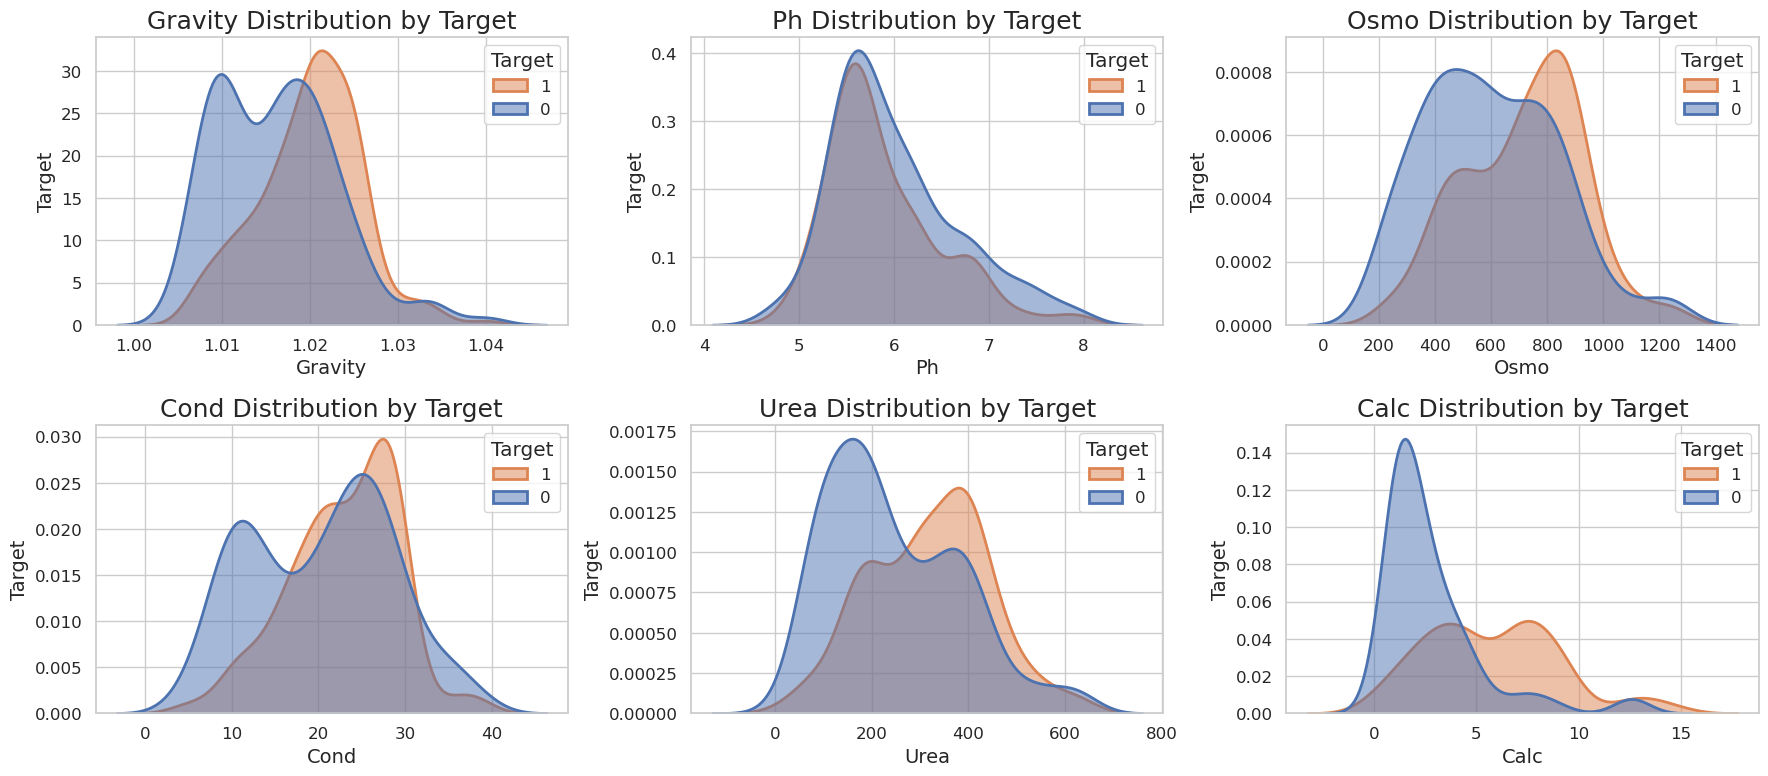

In [90]:
dist_by_target(train = train_bin, test = test_bin, target_col = "target")

### Partial Dependency Plots

In [91]:
original_features = list(test_bin.columns)

target = "target"

In [92]:
original_features

['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

In [99]:
def partial_independent(train = None , original_features = None):
    
   
    model = RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1)
    model.fit(train[original_features], train[target])

    features_for_pdp = original_features
    fig, axs = plt.subplots(2, 4, figsize=(12, 5))
    plt.suptitle('Partial Dependence', y=1.0)
    PartialDependenceDisplay.from_estimator(model, train[original_features],
                                            features_for_pdp,
                                            pd_line_kw={"color": "red"},
                                            ice_lines_kw={"color": "blue"},
                                            kind='both',
                                            ax=axs.ravel()[:len(features_for_pdp)])
    plt.tight_layout(h_pad=0.3, w_pad=0.5)
    plt.show()

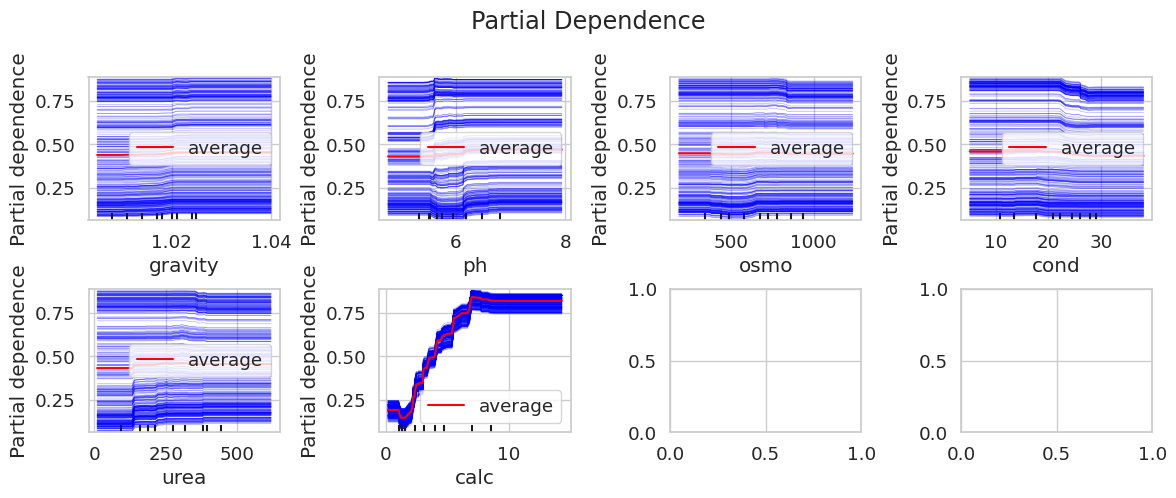

In [100]:
partial_independent(train_bin, original_features)